
# Stereo 3D Reconstruction: F → E → (R,t) → 3D

This notebook implements the full assignment workflow:

1. Feature detection & matching
2. Fundamental matrix (RANSAC + normalized 8-point)
3. Epipolar line visualization
4. Essential matrix using intrinsics K
5. Pose recovery (R, t)
6. Triangulation to 3D
7. (Optional) Uncalibrated rectification + SGBM
8. Export to PLY


In [ ]:

# ===== Setup (EDIT THIS) =====
left_img_path  = "/Users/ainee_f/Documents/School - Docs/computer_vision/homework04/images/old/PXL_20251029_011833481.jpg"   # TODO: replace with your image
right_img_path = "/Users/ainee_f/Documents/School - Docs/computer_vision/homework04/images/old/PXL_20251029_011836040.jpg"  # TODO: replace with your image

# left_img_path = "/Users/ainee_f/Documents/School - Docs/computer_vision/homework04/images/third/PXL_20251029_020234863.jpg"
# right_img_path = "/Users/ainee_f/Documents/School - Docs/computer_vision/homework04/images/third/PXL_20251029_020240274.jpg"

import numpy as np

# K = np.array([
#     [1000.0,   0.0, 640.0],
#     [  0.0 ,1000.0, 360.0],
#     [  0.0 ,   0.0,   1.0]
# ], dtype=float)

K = np.array([
    [1.50518378e+04,   0.0, 2.02730379e+03],
    [  0.0 ,1.48409101e+04, 1.47855129e+03],
    [  0.0 ,   0.0,   1.0]
], dtype=float)



# Optional SGBM params if you run the bonus section
sgbm_num_disparities = 128   # multiple of 16
sgbm_block_size      = 7     # odd


In [68]:

# ===== Imports & helpers =====
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def show_side_by_side(imgL, imgR, titleL="Left", titleR="Right"):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(imgL[..., ::-1]); plt.title(titleL); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(imgR[..., ::-1]); plt.title(titleR); plt.axis("off")
    plt.show()


Left: (4080, 3072, 3) Right: (4080, 3072, 3)


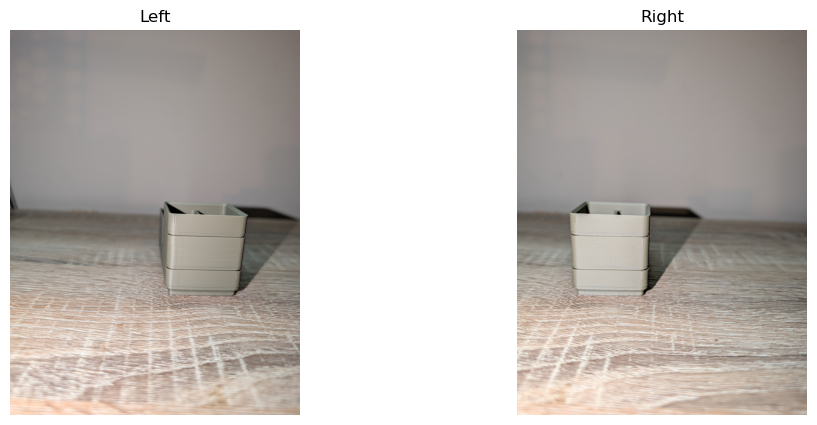

In [69]:

# ===== Load images =====
imgL = cv2.imread(left_img_path, cv2.IMREAD_COLOR)
imgR = cv2.imread(right_img_path, cv2.IMREAD_COLOR)
assert imgL is not None and imgR is not None, "Could not load images. Check your paths."
print("Left:", imgL.shape, "Right:", imgR.shape)
show_side_by_side(imgL, imgR)


Raw keypoints: L=5000 R=5000; good matches=82


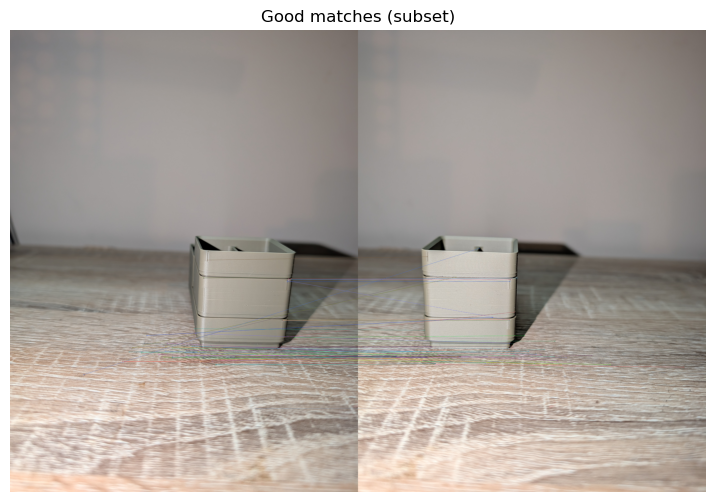

In [70]:

# ===== Detect & match features (ORB) =====
def detect_and_match(imgL, imgR, ratio=0.75):
    orb = cv2.ORB_create(nfeatures=5000)
    k1, d1 = orb.detectAndCompute(imgL, None)
    k2, d2 = orb.detectAndCompute(imgR, None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    knn = bf.knnMatch(d1, d2, k=2)
    good = []
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append(m)
    print(f"Raw keypoints: L={len(k1)} R={len(k2)}; good matches={len(good)}")
    return k1, k2, good

kps1, kps2, good_matches = detect_and_match(imgL, imgR)

vis = cv2.drawMatches(imgL, kps1, imgR, kps2, good_matches[:120], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,6)); plt.imshow(vis[..., ::-1]); plt.title("Good matches (subset)"); plt.axis("off"); plt.show()

pts1 = np.float32([kps1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kps2[m.trainIdx].pt for m in good_matches])


In [71]:

# ===== Normalized 8-point + RANSAC =====
def normalize_points(xy):
    mean = np.mean(xy, axis=0)
    d = xy - mean
    mean_dist = np.mean(np.sqrt(np.sum(d**2, axis=1))) + 1e-12
    s = np.sqrt(2.0) / mean_dist
    T = np.array([[s, 0, -s*mean[0]],
                  [0, s, -s*mean[1]],
                  [0, 0, 1]], dtype=float)
    xy_h = np.hstack([xy, np.ones((xy.shape[0],1))])
    xy_n = (T @ xy_h.T).T[:, :2]
    return xy_n, T

def eight_point_F(xy1, xy2):
    x1n, T1 = normalize_points(xy1)
    x2n, T2 = normalize_points(xy2)
    x1 = np.hstack([x1n, np.ones((x1n.shape[0],1))])
    x2 = np.hstack([x2n, np.ones((x2n.shape[0],1))])
    A = np.stack([
        x2[:,0]*x1[:,0], x2[:,0]*x1[:,1], x2[:,0],
        x2[:,1]*x1[:,0], x2[:,1]*x1[:,1], x2[:,1],
        x1[:,0],         x1[:,1],         np.ones(x1.shape[0])
    ], axis=1)
    _, _, VT = np.linalg.svd(A)
    f = VT[-1]
    F = f.reshape(3,3)
    U, S, VT = np.linalg.svd(F)
    S[-1] = 0.0
    F_rank2 = U @ np.diag(S) @ VT
    F_denorm = T2.T @ F_rank2 @ T1
    return F_denorm / (F_denorm[2,2] + 1e-12)

F_ransac, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.999)
inliers1 = pts1[mask.ravel()==1]
inliers2 = pts2[mask.ravel()==1]
print("RANSAC inliers:", inliers1.shape[0], "/", pts1.shape[0])

F = eight_point_F(inliers1, inliers2)
print("F =\n", F)


RANSAC inliers: 33 / 82
F =
 [[-2.18025787e-09 -3.26867195e-07  9.25504925e-04]
 [ 3.23853290e-07 -1.14682506e-09 -9.40185823e-05]
 [-9.13125789e-04 -2.56503067e-04  1.00000000e+00]]


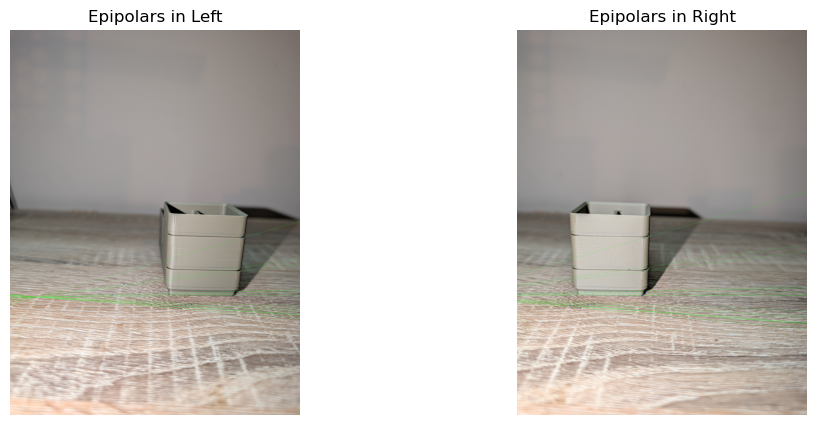

In [72]:

# ===== Epipolar line visualization =====
def draw_epipolars(F, imgL, imgR, pts1, pts2, num=16):
    h1, w1 = imgL.shape[:2]
    h2, w2 = imgR.shape[:2]
    n = min(num, len(pts1))
    idx = np.random.choice(len(pts1), size=n, replace=False)
    p1 = pts1[idx]; p2 = pts2[idx]
    p1_h = np.hstack([p1, np.ones((p1.shape[0],1))])
    p2_h = np.hstack([p2, np.ones((p2.shape[0],1))])
    linesR = (F @ p1_h.T).T
    linesL = (F.T @ p2_h.T).T
    L = imgL.copy(); R = imgR.copy()
    for (a,b,c), pt in zip(linesR, p2):
        x0, y0 = 0, int(-c/b) if abs(b) > 1e-9 else 0
        x1, y1 = w2-1, int(-(c + a*(w2-1))/b) if abs(b) > 1e-9 else h2-1
        cv2.line(R, (x0,y0), (x1,y1), (0,255,0), 1)
        cv2.circle(R, tuple(np.int32(pt)), 4, (255,0,0), -1)
    for (a,b,c), pt in zip(linesL, p1):
        x0, y0 = 0, int(-c/b) if abs(b) > 1e-9 else 0
        x1, y1 = w1-1, int(-(c + a*(w1-1))/b) if abs(b) > 1e-9 else h1-1
        cv2.line(L, (x0,y0), (x1,y1), (0,255,0), 1)
        cv2.circle(L, tuple(np.int32(pt)), 4, (255,0,0), -1)
    show_side_by_side(L, R, "Epipolars in Left", "Epipolars in Right")

draw_epipolars(F, imgL, imgR, inliers1, inliers2, num=16)


In [73]:

# ===== Essential matrix, pose (R,t), triangulation =====
E = K.T @ F @ K
U, S, VT = np.linalg.svd(E)
Smean = 0.5*(S[0]+S[1])
E = U @ np.diag([Smean, Smean, 0.0]) @ VT
print("E =\n", E)

retval, R, t, mask_pose = cv2.recoverPose(E, inliers1, inliers2, K)
print("Recovered pose inliers:", int(retval))
print("R =\n", R)
print("t (unit) =\n", t.ravel())

P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])
P2 = K @ np.hstack([R, t])

points4D = cv2.triangulatePoints(P1, P2, inliers1.T, inliers2.T)
points3D = (points4D[:3] / (points4D[3] + 1e-12)).T

def depth_positive(P, X):
    X_h = np.hstack([X, np.ones((X.shape[0],1))]).T
    Z = (P @ X_h)[2]
    return Z > 0

mask_ok = np.logical_and(depth_positive(P1, points3D), depth_positive(P2, points3D))
points3D = points3D[mask_ok]
print("3D points kept:", points3D.shape[0])


E =
 [[ -0.13861291 -72.29641488   6.56483765]
 [ 73.07346553  -0.59391528   8.43814172]
 [ -6.60251785 -13.50063582   0.47134835]]
Recovered pose inliers: 9
R =
 [[ 9.97490821e-01 -8.29676265e-03 -7.03080736e-02]
 [ 8.24533713e-03  9.99965485e-01 -1.02162065e-03]
 [ 7.03141231e-02  4.39343447e-04  9.97524802e-01]]
t (unit) =
 [-0.18355224  0.08811367  0.97905289]
3D points kept: 24


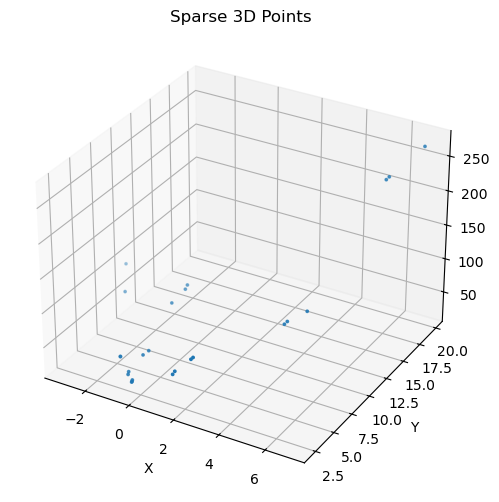

Saved: triangulated_points.ply


In [74]:

# ===== Visualize 3D & export PLY =====
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3D[:,0], points3D[:,1], points3D[:,2], s=3)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
ax.set_title("Sparse 3D Points")
plt.show()

def save_ply(filename, verts, rgb=None):
    verts = np.asarray(verts)
    if rgb is None:
        rgb = np.zeros_like(verts, dtype=np.uint8)
    header = "ply\nformat ascii 1.0\n" + f"element vertex {len(verts)}\n"
    header += "property float x\nproperty float y\nproperty float z\n"
    header += "property uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n"
    with open(filename, "w") as f:
        f.write(header)
        for (x,y,z), (r,g,b) in zip(verts, rgb):
            f.write(f"{x} {y} {z} {int(r)} {int(g)} {int(b)}\n")

ply_path = "triangulated_points.ply"
save_ply(ply_path, points3D)
print("Saved:", ply_path)



## Optional: Uncalibrated Rectification + SGBM
This tries to rectify using only F (no calibration), then computes a semi-dense disparity with SGBM.


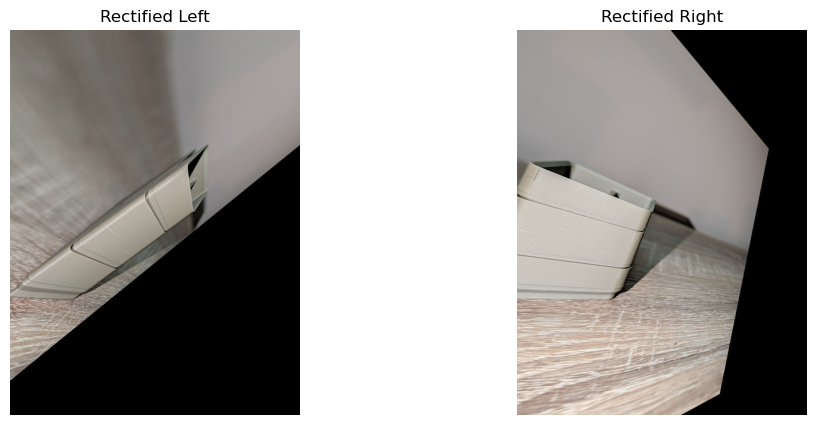

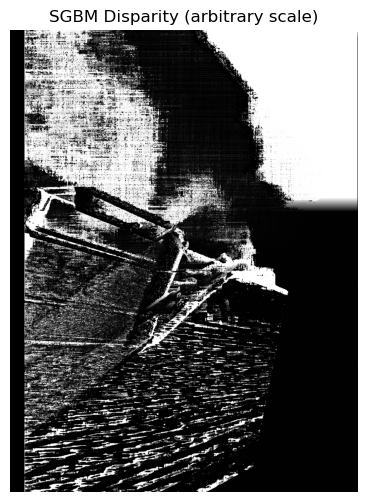

In [75]:

# ===== Optional: Rectification + SGBM =====
h, w = imgL.shape[:2]
retval, H1, H2 = cv2.stereoRectifyUncalibrated(inliers1, inliers2, F, imgSize=(w,h))
if retval:
    rectL = cv2.warpPerspective(imgL, H1, (w,h))
    rectR = cv2.warpPerspective(imgR, H2, (w,h))
    show_side_by_side(rectL, rectR, "Rectified Left", "Rectified Right")
    grayL = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

    min_disp = 0
    num_disp = sgbm_num_disparities
    blockSize = sgbm_block_size

    stereo = cv2.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=blockSize,
        P1=8*blockSize*blockSize,
        P2=32*blockSize*blockSize,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    disp = stereo.compute(grayL, grayR).astype(np.float32) / 16.0
    plt.figure(figsize=(8,6))
    plt.imshow(disp, cmap="gray")
    plt.title("SGBM Disparity (arbitrary scale)")
    plt.axis("off")
    plt.show()
else:
    print("Uncalibrated rectification failed. You can skip this section or try better matches.")
